# Process Discovery with the Alpha Algorithm in PM4PY

In [1]:
import pandas as pd
import numpy as np
from datetime import date
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
fn = 'ArtificialPatientTreatment.csv'
events = pd.read_csv(fn)

events.columns = ['patient', 'action', 'resource', 'datetime']
events['datetime'] = pd.to_datetime(events['datetime'])


In [3]:
#!pip install pm4py --user
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery


# viz
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.footprints import visualizer as fp_visualizer
from pm4py.visualization.transition_system import visualizer as ts_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# misc 
from pm4py.objects.petri_net.utils import reachability_graph
from pm4py.objects.conversion.process_tree import converter as pt_converter

import pm4py

In [4]:
eventlog = events.copy()
### Specify which columns correspond to case (case:concept:name), 
###event (concept:name) and timestamp (time:timestamp) - rename columns in accordance
###with pm4py

eventlog.rename(columns={'datetime': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)

## Convert to log format
log = log_converter.apply(eventlog)


### Log Exploration

In [5]:
# start activities
log_start = pm4py.get_start_activities(log)
log_start

{' First consult': 100}

In [6]:
# end activities
end_activities = pm4py.get_end_activities(log)
end_activities

{' Final consult': 100}

In [7]:
# activities
activities = pm4py.get_event_attribute_values(log, "concept:name")
print(activities)

{' First consult': 100, ' Blood test': 100, ' Physical test': 100, ' Second consult': 100, ' Surgery': 20, ' Final consult': 100, ' X-ray scan': 90, ' Medicine': 80}


### Analysis of binary relations

In [8]:
# footprint analysis
fp_log = footprints_discovery.apply(log, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)

In [9]:
fp_log['sequence']

{(' Blood test', ' Second consult'),
 (' First consult', ' Blood test'),
 (' First consult', ' Physical test'),
 (' First consult', ' X-ray scan'),
 (' Medicine', ' Final consult'),
 (' Physical test', ' Second consult'),
 (' Second consult', ' Medicine'),
 (' Second consult', ' Surgery'),
 (' Surgery', ' Final consult'),
 (' X-ray scan', ' Second consult')}

### Parallel

In [10]:
fp_log['parallel']

{(' Blood test', ' Physical test'),
 (' Blood test', ' X-ray scan'),
 (' Physical test', ' Blood test'),
 (' Physical test', ' X-ray scan'),
 (' X-ray scan', ' Blood test'),
 (' X-ray scan', ' Physical test')}

## Footprint table

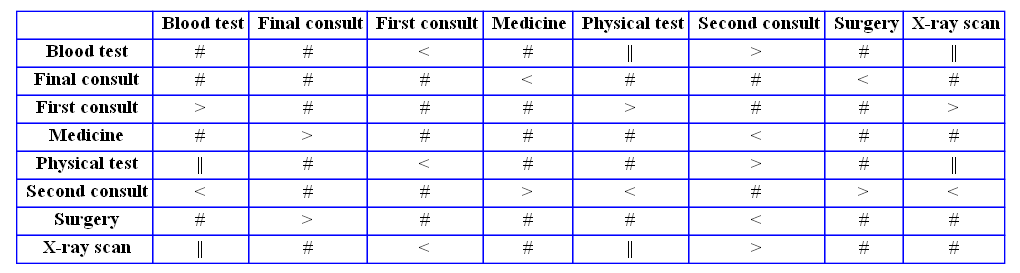

In [11]:
# caution: arrows mean "causality" here NOT "follows"
gviz = fp_visualizer.apply(fp_log)
fp_visualizer.view(gviz)

### Directly-follows graph

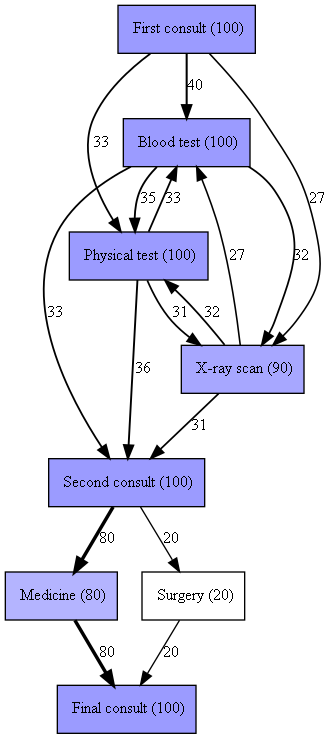

In [12]:
#Create graph from log (annotated with frequency)
dfg = dfg_discovery.apply(log)

# viz
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

### Alpha algorithm

In [13]:
# alpha miner
net, initial_marking, final_marking = alpha_miner.apply(log)

In [14]:
net

places: [ ({' Blood test'}, {' Second consult'}), ({' First consult'}, {' Blood test'}), ({' First consult'}, {' Physical test'}), ({' First consult'}, {' X-ray scan'}), ({' Medicine', ' Surgery'}, {' Final consult'}), ({' Physical test'}, {' Second consult'}), ({' Second consult'}, {' Medicine', ' Surgery'}), ({' X-ray scan'}, {' Second consult'}), end, start ]
transitions: [ ( Blood test, ' Blood test'), ( Final consult, ' Final consult'), ( First consult, ' First consult'), ( Medicine, ' Medicine'), ( Physical test, ' Physical test'), ( Second consult, ' Second consult'), ( Surgery, ' Surgery'), ( X-ray scan, ' X-ray scan') ]
arcs: [ ( Blood test, ' Blood test')->({' Blood test'}, {' Second consult'}), ( Final consult, ' Final consult')->end, ( First consult, ' First consult')->({' First consult'}, {' Blood test'}), ( First consult, ' First consult')->({' First consult'}, {' Physical test'}), ( First consult, ' First consult')->({' First consult'}, {' X-ray scan'}), ( Medicine, ' Me

In [15]:
initial_marking

['start:1']

In [16]:
final_marking

['end:1']

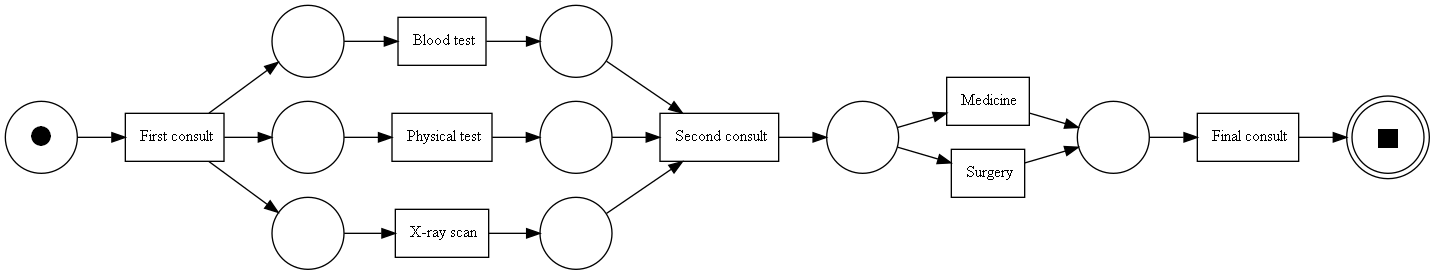

In [17]:
# Visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

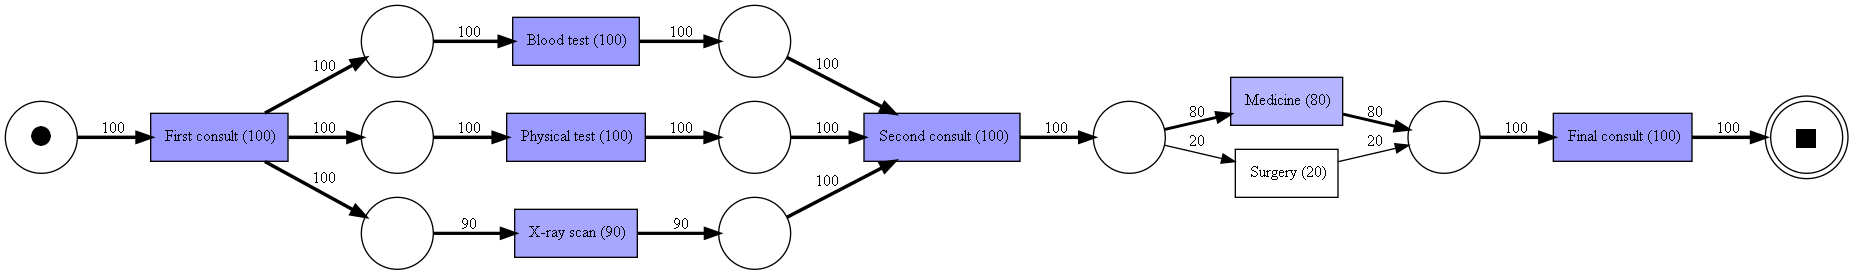

In [18]:
# add information about frequency to the viz 
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz2 = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

pn_visualizer.view(gviz2)

### Alternative Process Discovery Algorithm: Inductive Miner


In [19]:
net2, initial_marking2, final_marking2 = pm4py.discover_petri_net_inductive(log)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

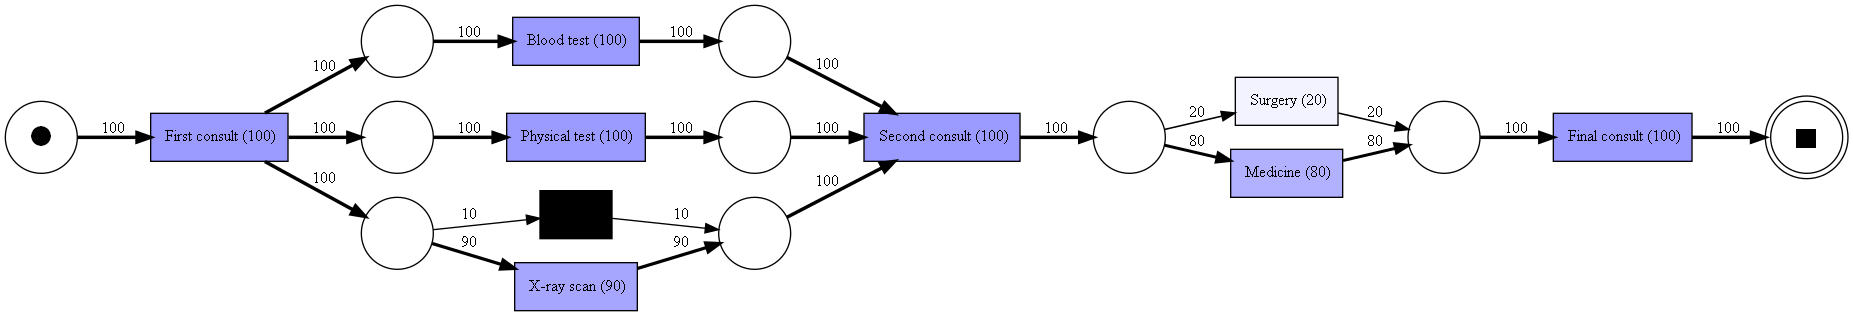

In [20]:
gviz3 = pn_visualizer.apply(net2, initial_marking2, final_marking2, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

pn_visualizer.view(gviz3)